<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/AbdelMahm/FSR/blob/master/IDDLO-29-20/Notebooks/PCA.ipynb"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" />Run in Google Colab</a>
  </td>
</table>

# Dimensionality Reduction

In [1]:
import sys
import sklearn
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.linear_model
import urllib.request
from sklearn import preprocessing
from sklearn import pipeline

### Load Data

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
# load dataset into Pandas DataFrame
df = pd.read_csv(url, names=['sepal length','sepal width','petal length','petal width','target'])
df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
from sklearn.preprocessing import StandardScaler
features = ['sepal length', 'sepal width', 'petal length', 'petal width']
# Separating out the features
X = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['target']].values
# Standardizing the features
X = StandardScaler().fit_transform(X)

### PCA components

In [4]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])

In [5]:
finalDf = pd.concat([principalDf, df[['target']]], axis = 1)
finalDf.head()

,PC1,PC2,target
0,-2.264542,0.505704,Iris-setosa
1,-2.086426,-0.655405,Iris-setosa
2,-2.367950,-0.318477,Iris-setosa
3,-2.304197,-0.575368,Iris-setosa
4,-2.388777,0.674767,Iris-setosa


### Visualization

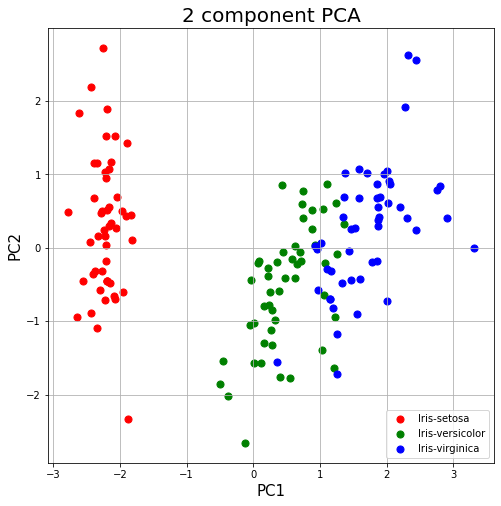

In [6]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [7]:
pca.explained_variance_ratio_

array([0.72770452, 0.23030523])

## PCA to speed up ML model

In [8]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=6/7, test_size=10000)

### Apply Logistic Regression without PCA

In [10]:
%%time
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train, y_train)
score = logisticRegr.score(X_test, y_test)
print(score)

0.9223
CPU times: user 24.7 s, sys: 634 ms, total: 25.4 s
Wall time: 15.4 s


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Apply Logistic Regression after PCA

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_scale = scaler.transform(X_train)
X_test_scale = scaler.transform(X_test)

In [12]:
from sklearn.decomposition import PCA
# Make an instance of the Model (retain 95% of the variance)
pca = PCA(.95)
pca.fit(X_train)
pca.n_components_

154

In [13]:
X_train_scale_pca = pca.transform(X_train_scale)
X_test_scale_pca = pca.transform(X_test_scale)

In [14]:
%%time
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(X_train_scale_pca, y_train)
score_pca = logisticRegr.score(X_test_scale_pca, y_test)
print(score_pca)

0.8798
CPU times: user 8.67 s, sys: 287 ms, total: 8.96 s
Wall time: 5.72 s


/Users/mac/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Return to Original Space (5% missed)

In [15]:
lower_dimensional_data = pca.fit_transform(X_train) # fit and transform in the same time

In [16]:
approximation = pca.inverse_transform(lower_dimensional_data)

KeyError: 2

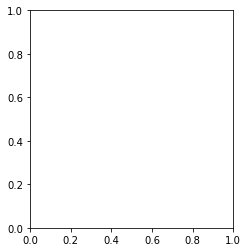

In [17]:
plt.figure(figsize=(8,4));

# Original Image
plt.subplot(1, 2, 1);
plt.imshow(X_train[2].reshape(28,28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('784 components', fontsize = 14)
plt.title('Original Image', fontsize = 20);

# 154 principal components
plt.subplot(1, 2, 2);
plt.imshow(approximation[2].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255));
plt.xlabel('154 components', fontsize = 14)
plt.title('95% of Explained Variance', fontsize = 20);

## PCA and KernelPCA

PCA explained variance ratio (first two components): [0.92461872 0.05306648]


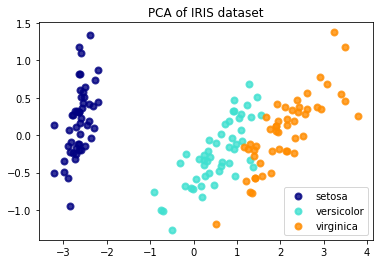

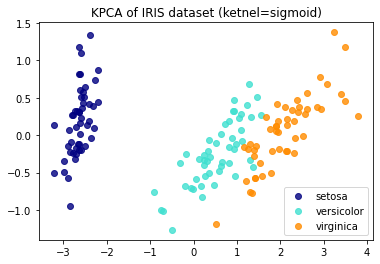

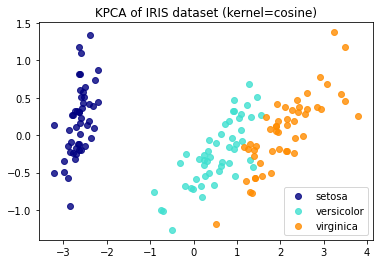

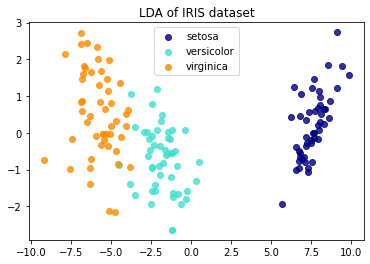

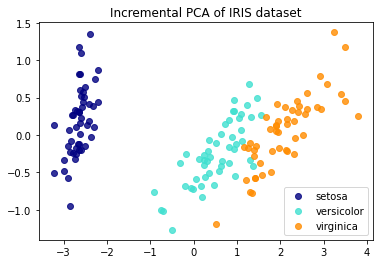

In [37]:

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA




iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

pca = PCA(n_components=2)
X_r = pca.fit(X,y).transform(X)


#Kernel Linear
k_pca1 = KernelPCA(n_components=2, kernel='sigmoid')
X_r1= k_pca.fit_transform(X,y)

#Kernel poly
k_pca2 = KernelPCA(n_components=2, kernel='cosine')
X_r2= k_pca.fit_transform(X,y)

lda = LinearDiscriminantAnalysis(n_components=2)
X_r3 = lda.fit(X, y).transform(X)

IncrementalPCA = IncrementalPCA(n_components=2)
X_r4=IncrementalPCA.fit_transform(X,y)

# Percentage of variance explained for each components
print(
    "PCA explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)


plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r1[y == i, 0], X_r1[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("KPCA of IRIS dataset (ketnel=sigmoid)")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r2[y == i, 0], X_r2[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("KPCA of IRIS dataset (kernel=cosine)")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r3[y == i, 0], X_r3[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA of IRIS dataset")

plt.figure()
for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r4[y == i, 0], X_r4[y == i, 1], alpha=0.8, color=color, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("Incremental PCA of IRIS dataset")

plt.show()